# Statistical Methods Project

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats.mstats import winsorize
import statsmodels.formula.api as smf
import statsmodels.api as sm

# EDA (data description, data preprocessing)

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/ov3ipo/SM_Project/main/life_expectancy.csv")
# remove trailing space in columns name and format display function
pd.options.display.float_format = '{:.4f}'.format
df = df.rename(columns=lambda x: x.strip())

# overview on data statistic
display(df.head(10))
display(df.info())

# get quantitative and qualitative data
numeric_cols = df.drop(columns=["Status", "Country"], axis=1).columns

10 rows × 22 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

None

## Data description

### Univariate

#### Qualitative

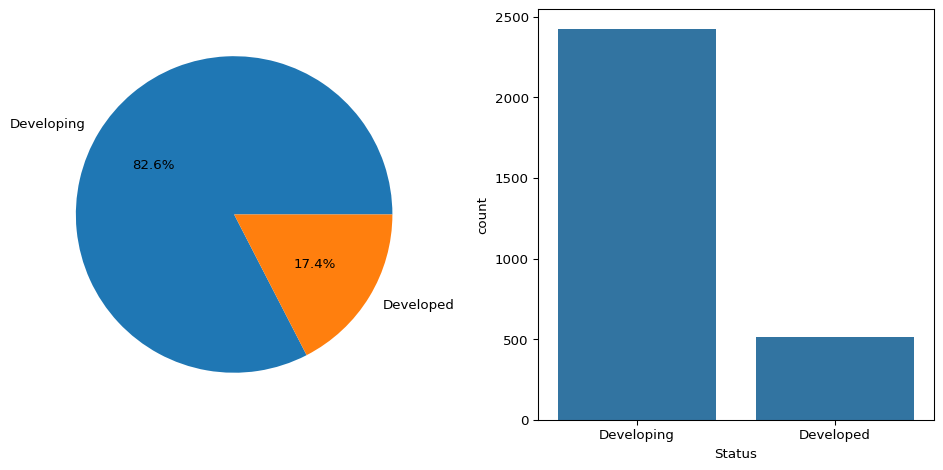

In [3]:
plt.figure(figsize = (10,5))
plt.subplot(1, 2, 1)
x = df['Status'].value_counts().reset_index()
plt.pie(x=x['count'], labels=x['Status'], autopct="%0.1f%%")
plt.subplot(1, 2, 2)
sns.countplot(df, x="Status")
plt.tight_layout()
plt.show()

``` {markdown}
Remark:
- Why didn't we consider the Country col in this case?
- State what you see in the chart
```

#### Quantitative

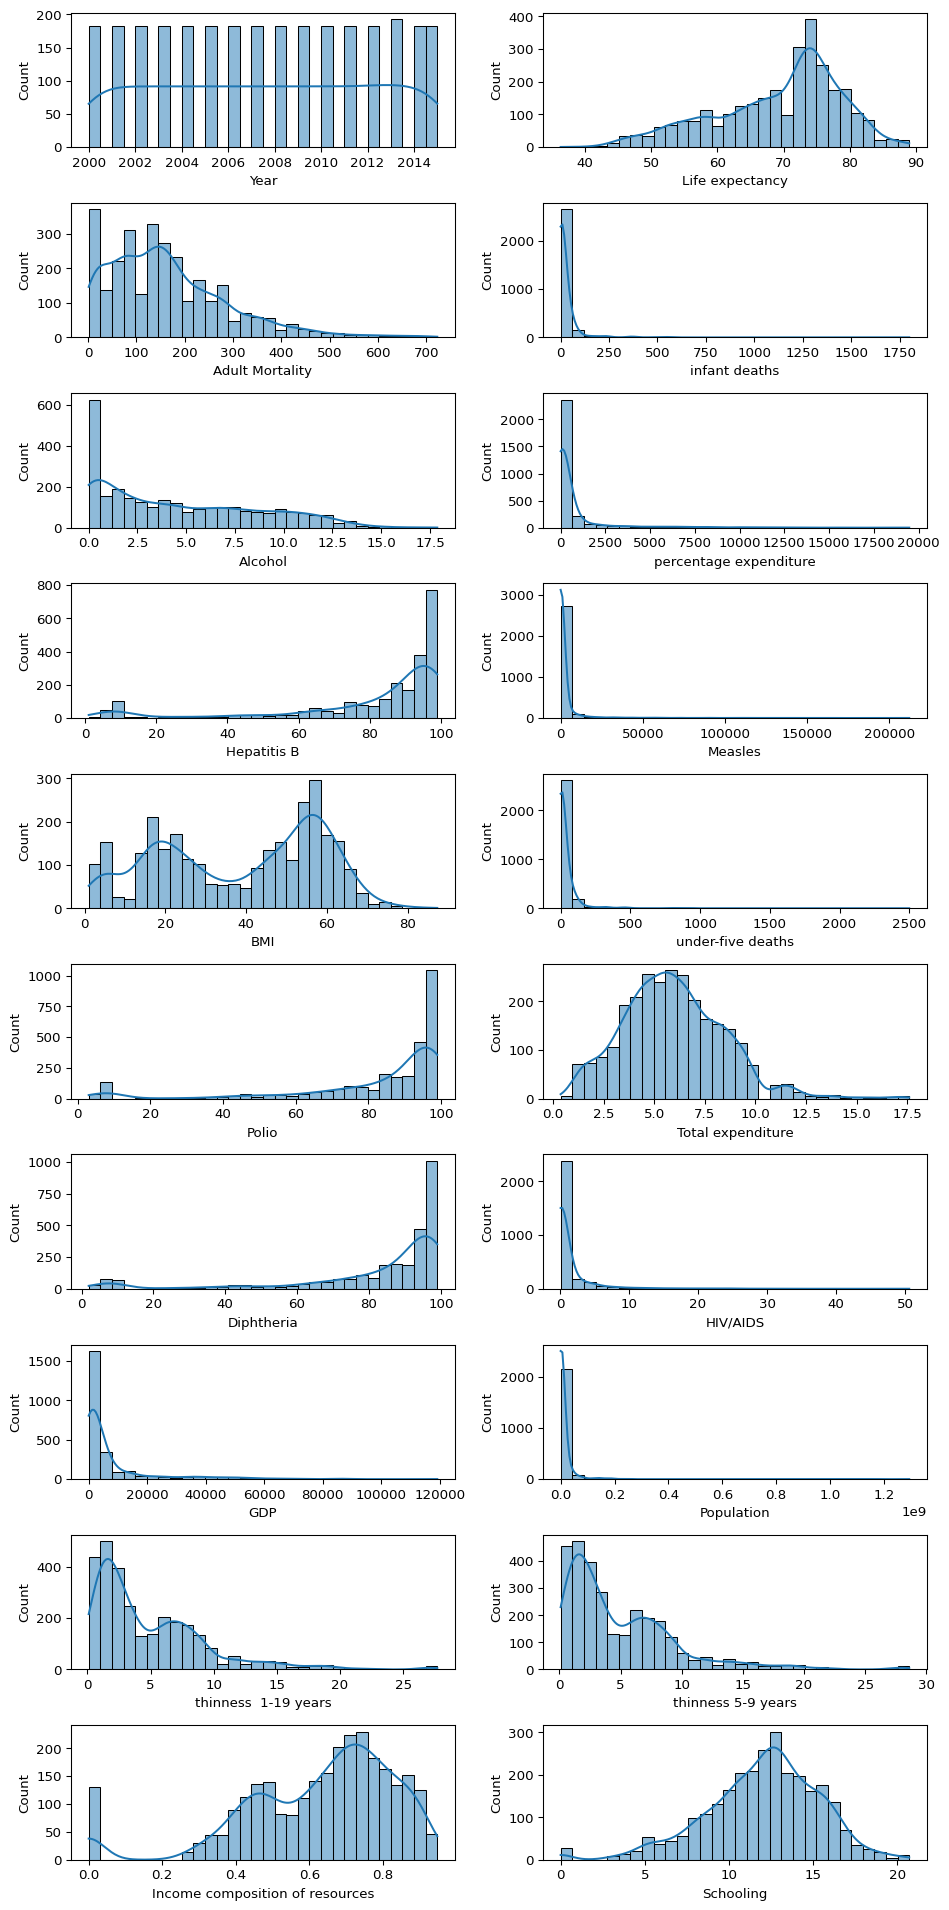

In [4]:
plt.figure(figsize=(10, 20))
for i, col in enumerate(numeric_cols):
    plt.subplot(10, 2, i + 1)
    sns.histplot(df, x=col, bins=30, kde=True)
plt.tight_layout()
plt.show()

``` {markdown}
Remark:
- State what you see in the chart
```

### Bivariate

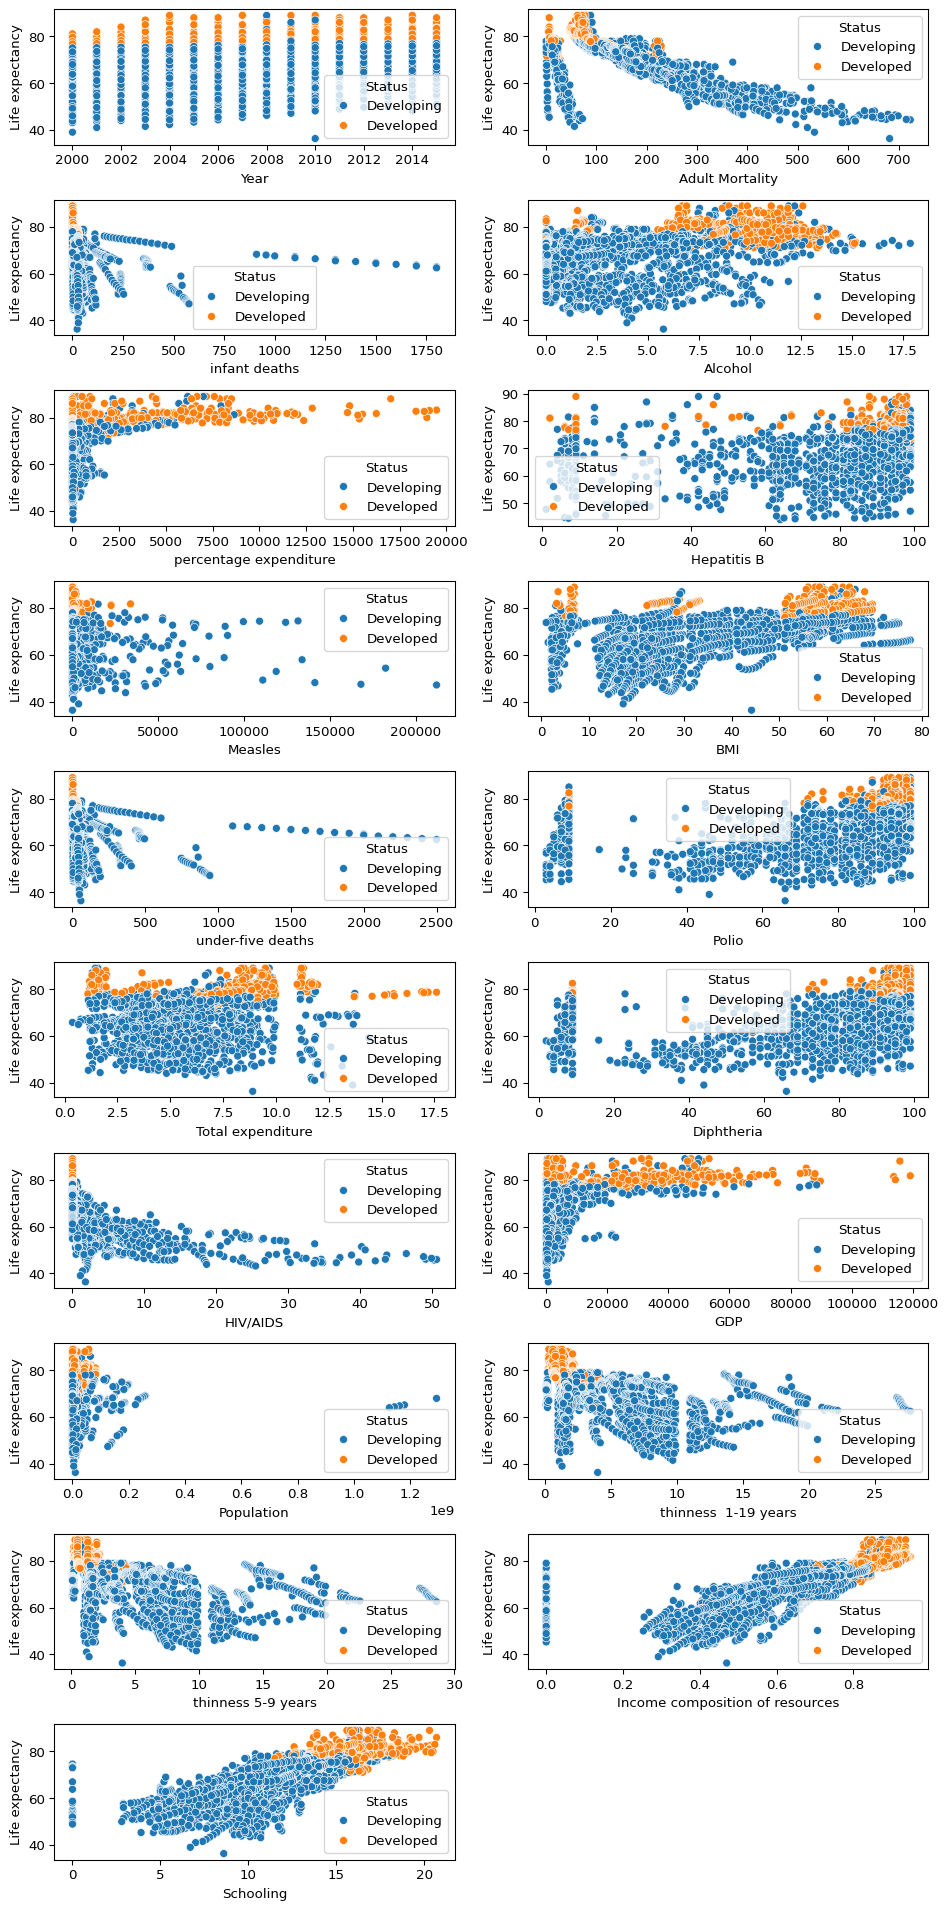

In [5]:
plt.figure(figsize=(10, 20))
index = np.argwhere(numeric_cols=="Life expectancy")
for i, col in enumerate(np.delete(numeric_cols, index)):
    plt.subplot(10, 2, i + 1)
    sns.scatterplot(df, x=col, y="Life expectancy", hue="Status", legend="auto")
plt.tight_layout()
plt.show()

``` {markdown}
Remark:
- State what you see in the chart
- Base on the scatter plot can you spot any variables that seem to have a linear relationship with the target variabel?
```

### Overall statistic

In [6]:
display(df.describe().T)

## Data preprocessing (NAs, outliers, duplicateds, label encoding)

### Missing

In [7]:
print("\nPreprocessing\n")
print(df.isna().sum())
df = df.interpolate(method='linear', limit_direction='forward')
print("\nPostprocessing\n")
print(df.isna().sum())


Preprocessing

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Population                         652
thinness  1-19 years                34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64

Postprocessing

Country                            0
Year                               0
Status                

/tmp/ipykernel_138826/365239556.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear', limit_direction='forward')

### Duplicated

In [8]:
print(f"Total duplicated values: {df.duplicated().sum()}")

Total duplicated values: 0

### Outliers

#### Detect outliers

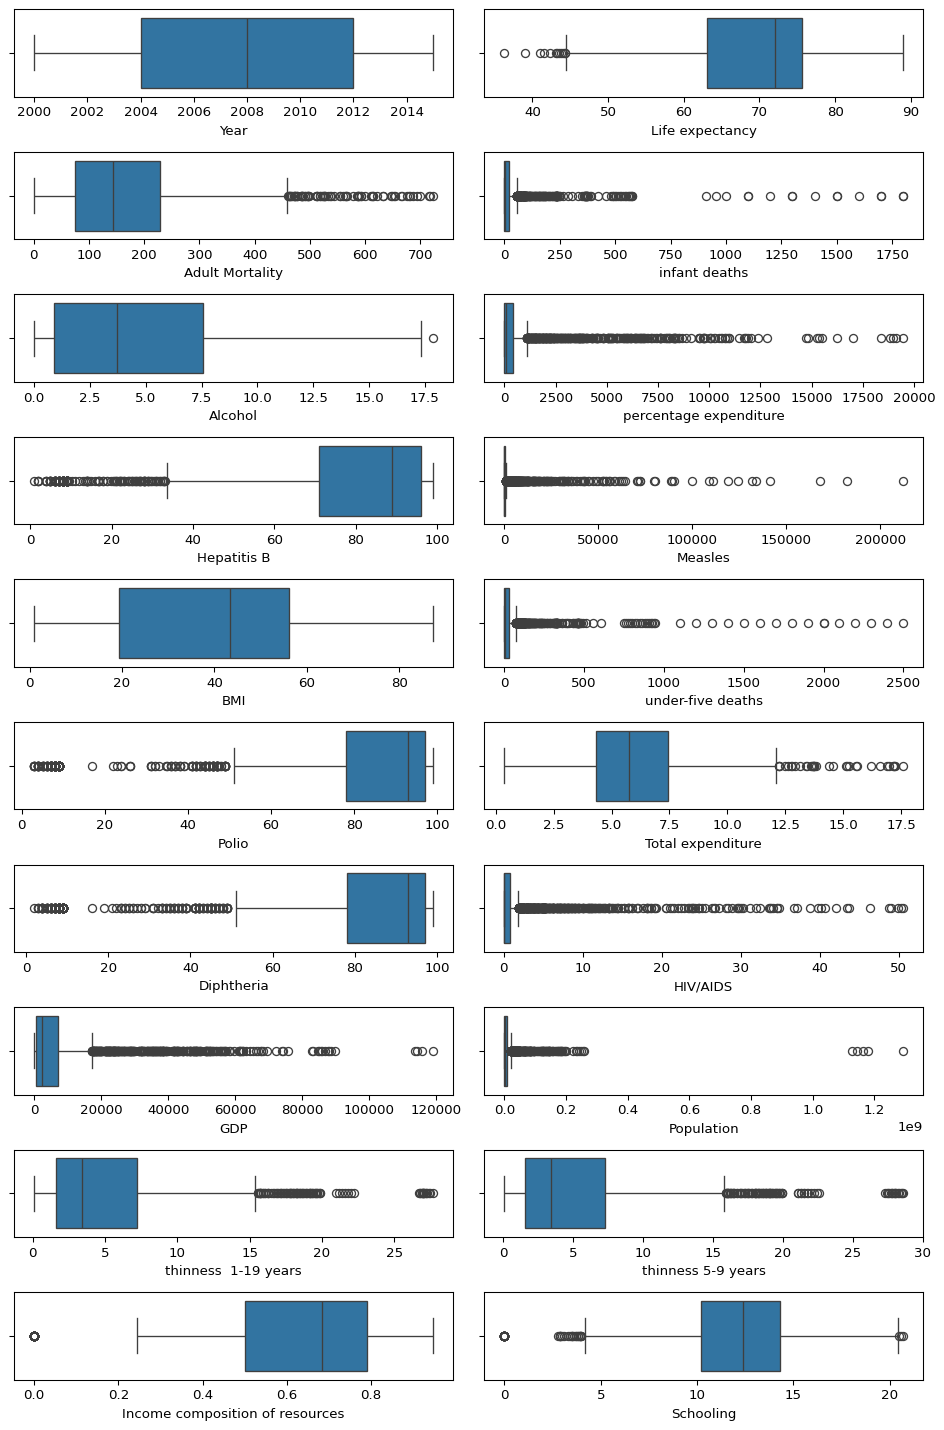

In [9]:
plt.figure(figsize=(10, 15))
for i, col in enumerate(numeric_cols):
    plt.subplot(10, 2, i + 1)
    sns.boxplot(df, x=col)
plt.tight_layout()
plt.show()

# detect outliers
def detectOutliers(data):
    outliers_arr = []
    for col in data.columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col].count()
        outliers_arr.append(outliers)
    return pd.DataFrame(outliers_arr, index=data.columns, columns=["Total outliers"])

numeric_data = df.drop(columns=["Status", "Country"], axis=1)
outliers = detectOutliers(numeric_data)
outliers

``` {markdonw}
Why we should not use variable with high outliers -> because regression can heavily be affected by these outliers, hence we should only choose those with low outliers
Potential variable for regression of target
- Year
- Adult Mortality
- Alcohol
- BMI
- Total expenditure
- thinness 1-19 years
- thinness 5-9 years
- Income composition of resources
- Schooling
```

#### Dealing with outliers

In [10]:
# get potentital variables and variables that have outliers
potential_var = outliers[(outliers["Total outliers"] < 150)].index
outliers_var = outliers[(outliers["Total outliers"] > 0) & (outliers["Total outliers"] < 150)].index

# using transformation to deal with outliers
df_outliers = df.copy()
for col in outliers_var:
    if col != "Life expectancy":
        df_outliers[col] = np.sqrt(df_outliers[col])

# detect outliers again
display(detectOutliers(df_outliers[potential_var]))

# notice that outliers of Total expenditure, Income composition of resources and schooling does not change and or increase
for col in ["Total expenditure", "Income composition of resources", "Schooling"]:
    df_outliers[col] = df[col]
    df_outliers[col] = winsorize(df_outliers[col], limits=[0.05, 0.05])

# detect outliers again
display(detectOutliers(df_outliers[potential_var]))

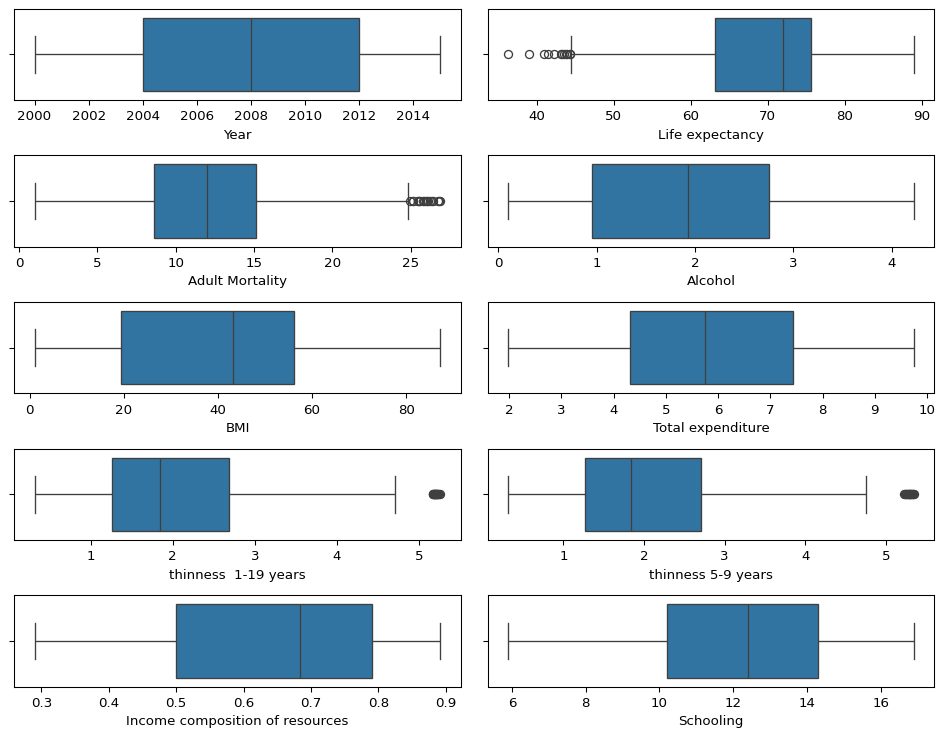

In [11]:
# plot outliers
plt.figure(figsize=(10, 15))
for i, col in enumerate(potential_var):
    plt.subplot(10, 2, i + 1)
    sns.boxplot(df_outliers, x=col)
plt.tight_layout()
plt.show()

# assign new dataframe to use for regression
df_regress = df_outliers[potential_var]

``` {markdown}
Remark
- Explain reason why we should not use variables that have many outliers
- Explain reason why we choose to use transformation and why is log (or anything else)
```

### Comprare preprocess and postprocess

In [12]:
# compare statistic
display(df[potential_var].describe().T)
display(df_regress.describe().T)

``` {markdown}
Remark:
- State what you observe when compare the two tables
```

# Linear Regression Analysis

## Correlation Matrix

### Before dealing with outliers

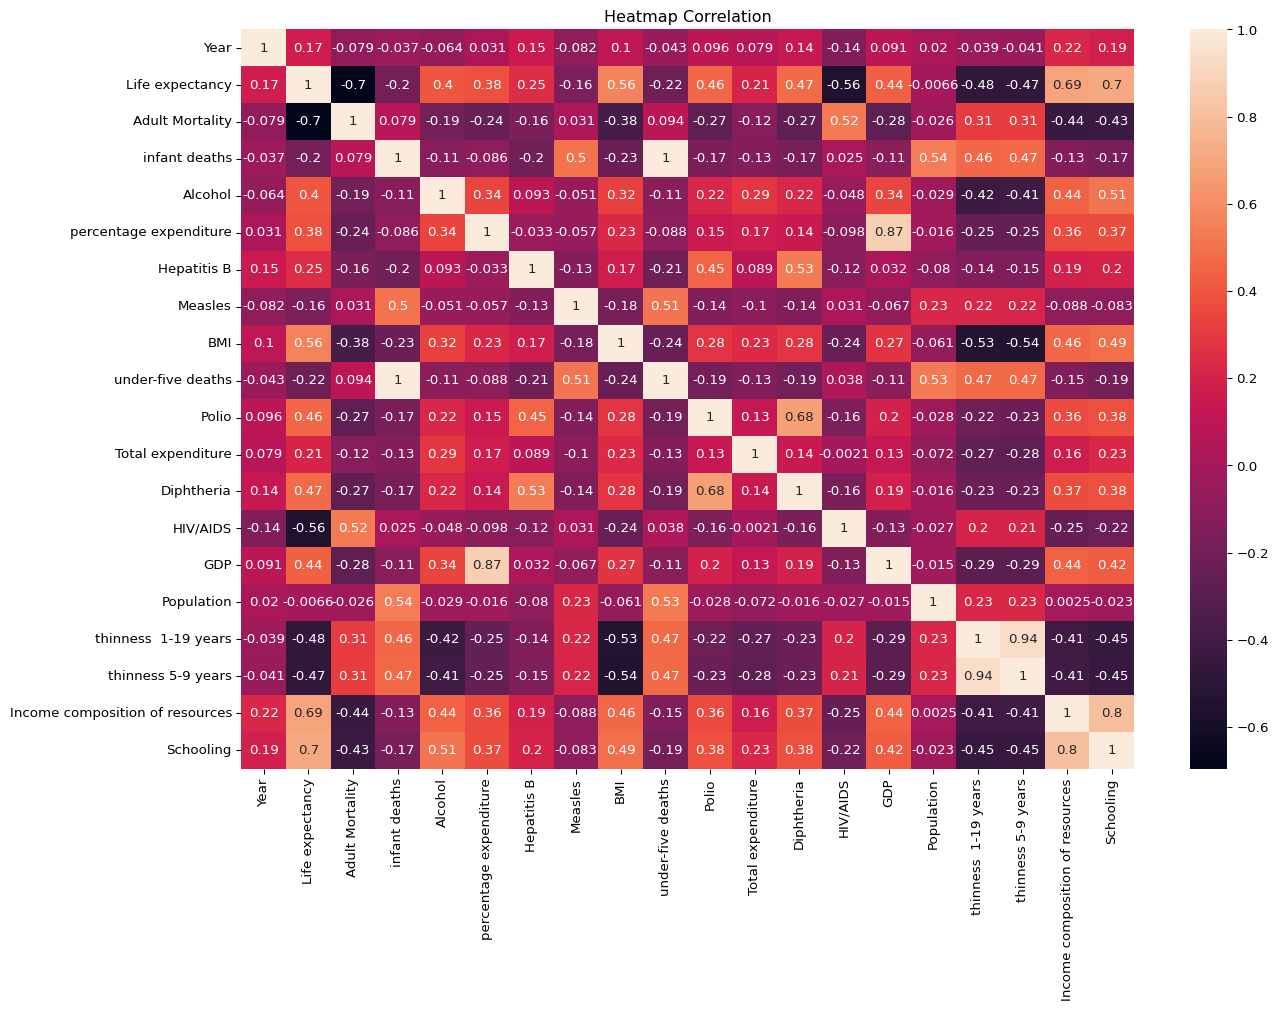

Variables have correlation larger than 0.5: 

Adult Mortality                   -0.6957
BMI                                0.5564
HIV/AIDS                          -0.5559
Income composition of resources    0.6909
Schooling                          0.7043
Name: Life expectancy, dtype: float64

In [13]:
numeric_df = df.drop(columns=["Country", "Status"])
plt.figure(figsize=(15, 10))
sns.heatmap(numeric_df.corr(), annot=True)
plt.title('Heatmap Correlation')
plt.show()

# get variables that has high correlation with Life expectancy
corrs = numeric_df.corr()['Life expectancy'].drop('Life expectancy')
high_corr = corrs[corrs.abs() > 0.5]
print("Variables have correlation larger than 0.5: ")
high_corr

### After dealing with outliers

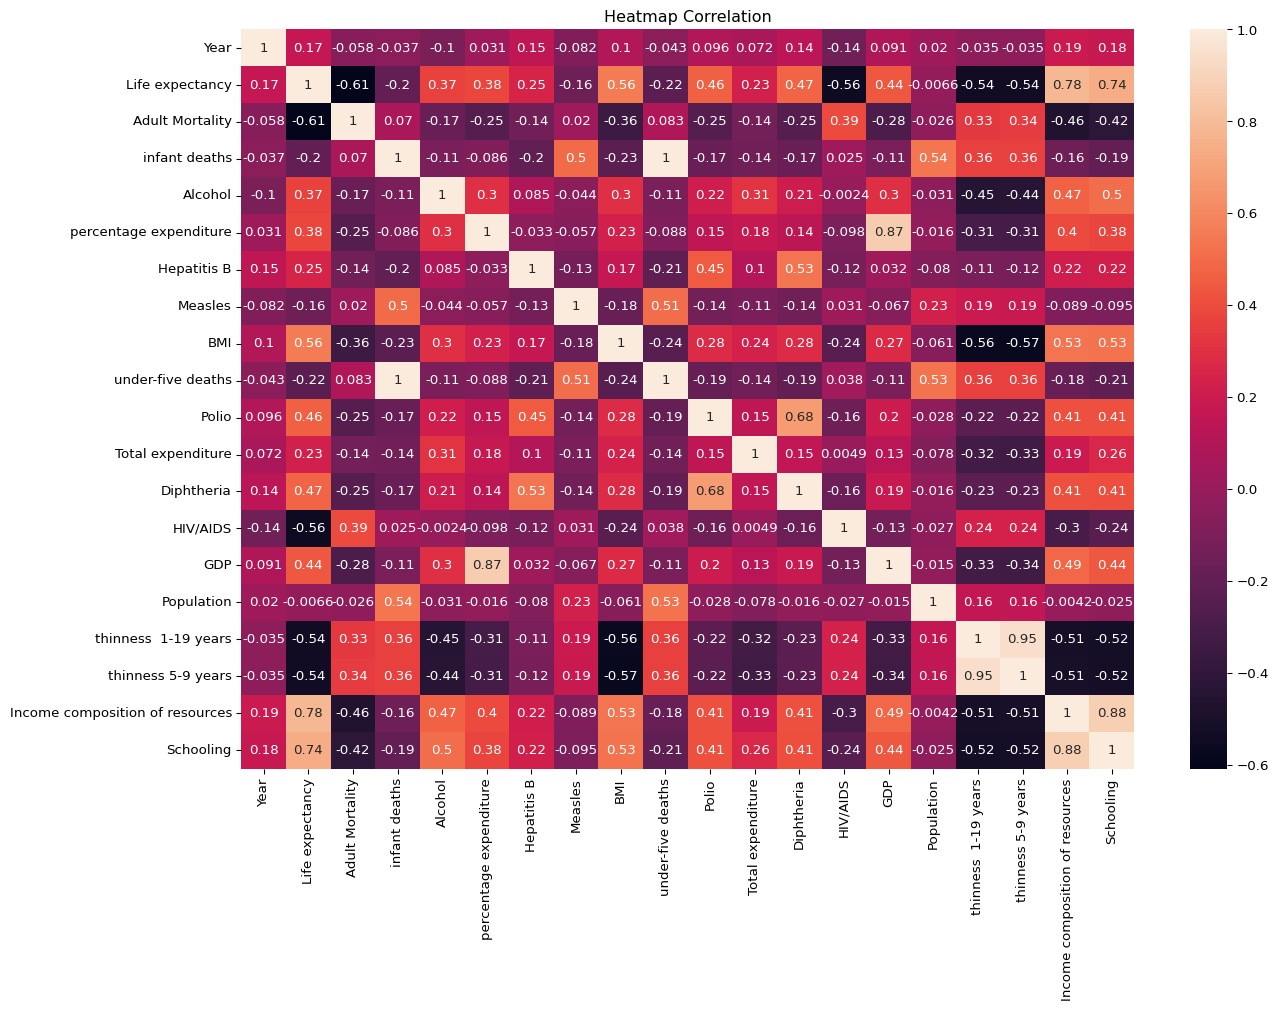

Variables have correlation larger than 0.5: 

Adult Mortality                   -0.6085
BMI                                0.5564
HIV/AIDS                          -0.5559
thinness  1-19 years              -0.5355
thinness 5-9 years                -0.5379
Income composition of resources    0.7837
Schooling                          0.7375
Name: Life expectancy, dtype: float64

In [14]:
numeric_df_outliers = df_outliers.drop(columns=["Country", "Status"])
plt.figure(figsize=(15, 10))
sns.heatmap(numeric_df_outliers.corr(), annot=True)
plt.title('Heatmap Correlation')
plt.show()

# get variables that has high correlation with Life expectancy
corrs = numeric_df_outliers.corr()['Life expectancy'].drop('Life expectancy')
high_corr = corrs[corrs.abs() > 0.5]
print("Variables have correlation larger than 0.5: ")
high_corr

Remark
- We have 8 variables having correlation larger than 0.5.
- Base on the heatmap above, we have two couples "Schooling"-"Income composition of resources",and "thinness  1-19 years"-"thinness 5-9 years " have high correlation with each other, so they are multicollinearity and do not satisfy the condition of linear regression.
- According to the outliers detection in the previous step, we can see that "HIV/AIDS" have more outliers than the others.
- Therefore, This leaves us with the last 2 variables that is BMI and Adult Mortality, hence we will use them for linear regression. 

In [15]:
# update data use for regress
df_regress = df_regress[["Life expectancy", "BMI", "Adult Mortality"]]

``` {markdown}
Remark
- Base on qualitative analysis remark, outliers detection remark, and this correlation matix make the final conclusion on which variable we should use for linear regression of target
- thiness 1-19 and 5-9 have high correlation with each other, also for income composition of resources make them not satisfy the condition of linear regression that is each variables should be independent
- HIV/AIDS is introduced in here but it has too much outliers hence we will skip it
- This leaves us with the last 2 variables that is BMI and Adult Mortality, hence we will use them for linear regression
```

## Least square regression

### $ \hat{Y} = Intercept + Slope*X $
$Slope = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^{n}(x_i - \bar{x})^2}                   $ <br>
$Intercept = \bar{y} - Slope*\bar{x}$               <br>
<br>
$R^2 = \frac{\sum_{i=1}^n (\hat{y}i - \bar{y})^2}{\sum{i=1}^n (y_i - \bar{y})^2}$ <br>
<br>
The coefficient of determination, $R^2$, measures the proportion of the variance in the dependent variable that is predictable from the independent variable(s). It ranges from 0 to 1, with a higher value indicating a better fit of the model to the data.

In [16]:
X1 = df_regress['Adult Mortality']
X2 = df_regress['BMI']
y = df_regress['Life expectancy']

model1 = smf.ols(formula='y ~ X1', data=df_regress).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     1726.
Date:                Thu, 30 May 2024   Prob (F-statistic):          3.98e-297
Time:                        20:55:56   Log-Likelihood:                -10107.
No. Observations:                2938   AIC:                         2.022e+04
Df Residuals:                    2936   BIC:                         2.023e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     82.9944      0.360    230.707      0.0

Remark
- The R-squared value is 0.370. This indicates that the independent variable(s), "Adult Mortality", in the model explain 37.0% of the variation in the dependent variable. 
- The Adjusted R-squared value is also 0.370, which suggests that the inclusion of additional predictor variables would not significantly improve the model's explanatory power.

In [17]:
model2 = smf.ols(formula='y ~ X2', data=df_regress).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     1317.
Date:                Thu, 30 May 2024   Prob (F-statistic):          1.61e-238
Time:                        20:55:56   Log-Likelihood:                -10242.
No. Observations:                2938   AIC:                         2.049e+04
Df Residuals:                    2936   BIC:                         2.050e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     59.0764      0.315    187.448      0.0

Remark
- The Adjusted R-squared value is 0.309, which indicates that the independent variables in the model explain approximately 30.9% of the variation in the dependent variable.

- The R-squared value is 0.310, which is slightly higher than the Adjusted R-squared. This suggests that the inclusion of additional predictor variables may not significantly improve the model's explanatory power.

In [18]:
model3 = smf.ols(formula='y ~ X1 + X2', data=df_regress).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     1481.
Date:                Thu, 30 May 2024   Prob (F-statistic):               0.00
Time:                        20:55:56   Log-Likelihood:                -9760.8
No. Observations:                2938   AIC:                         1.953e+04
Df Residuals:                    2935   BIC:                         1.955e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     72.7670      0.486    149.622      0.0

Remark

- The R-squared value is 0.502, indicating that the model explains 50.2% of the variation in the dependent variable.
- The Adjusted R-squared value is 0.502, which is the same as the R-squared value. This suggests that the inclusion of the independent variables in the model does not significantly improve the model's explanatory power beyond what the R-squared value already captures.


## Check residuals for 4 assumptions

### Assumption 1: Linearity

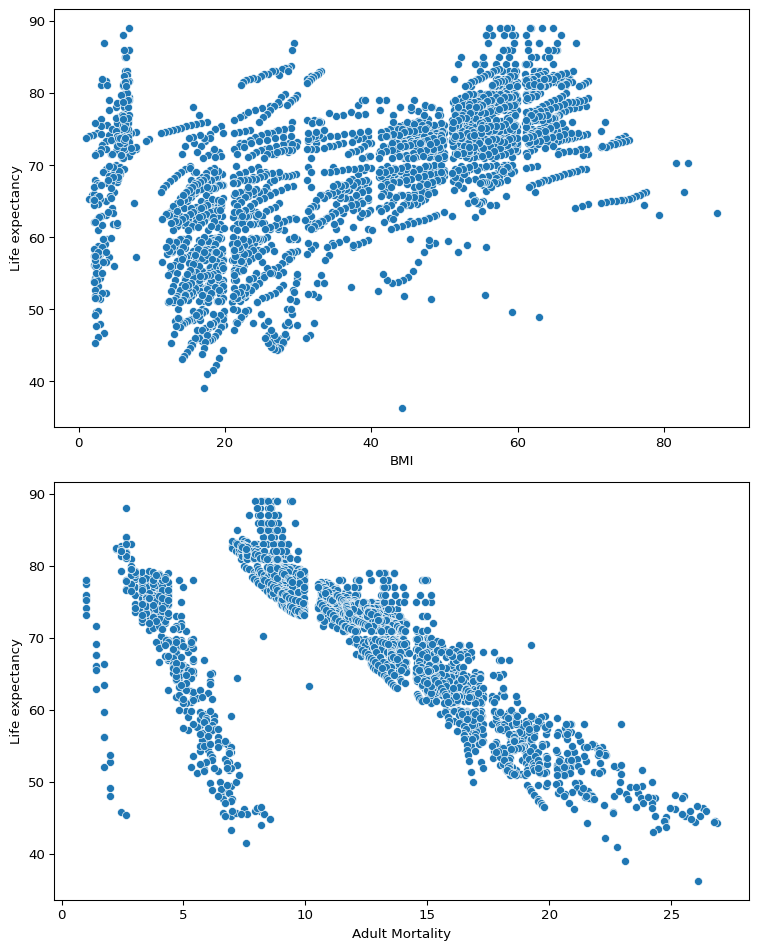

In [19]:
plt.figure(figsize=(8, 10))
for i, col in enumerate(df_regress.drop(['Life expectancy'], axis=1).columns):
    plt.subplot(2, 1, i + 1)
    sns.scatterplot(df_regress, x=col, y="Life expectancy")
plt.tight_layout()
plt.show()

``` {markdonw}
Remark
- What does the chart conclude about the liearity?
- What to do if this assumption is violated?
```

### Assumption 2: Independent

``` {markdonw}
Remark
- What does the chart conclude about the linearity?
- What to do if this assumption is violated?
```

### Assumption 3: Homoscedasticity

``` {markdonw}
Remark
- What does the chart conclude about the linearity?
- What to do if this assumption is violated?
```

### Assumption 4: Normality of Residuals

In [20]:
# test = shapiro(df_regress[])
# print(f'Test statistic = {test[0]}, p-value = {test[1]}')
# if test[1] > 0.05: print(f'{col} looks normal distributed (fail to reject H0)\n')
# else: print(f'{col} does not normal distributed (reject H0)\n')

``` {markdonw}
Remark
- What does the chart conclude about the linearity?
- What to do if this assumption is violated?
```

## Normality check

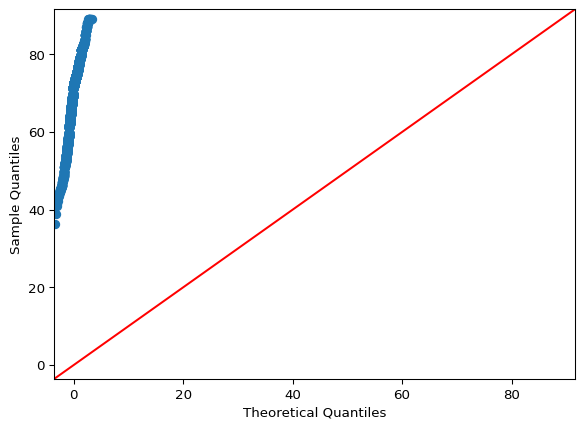

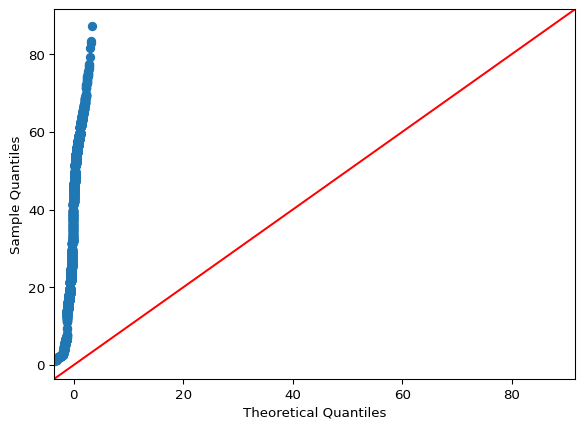

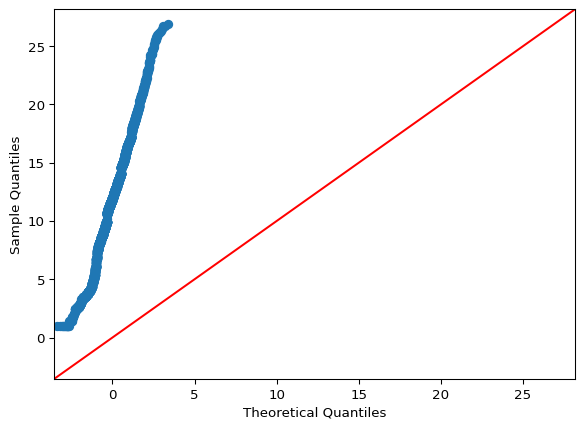

In [21]:
# add semicolon to prevent duplicated graph issue
sm.qqplot(df_regress["Life expectancy"], line='45');
sm.qqplot(df_regress['BMI'], line='45');
sm.qqplot(df_regress['Adult Mortality'], line='45');

In [22]:
# use Shapiro-Wilk test to test again
for col in df_regress.columns:
    test = shapiro(df_regress[col])
    print(f'Test statistic = {test[0]}, p-value = {test[1]}')
    if test[1] > 0.05: print(f'{col} looks normal distributed (fail to reject H0)\n')
    else: print(f'{col} does not normal distributed (reject H0)\n')

Test statistic = 0.9566212771358409, p-value = 9.704783341258267e-29
Life expectancy does not normal distributed (reject H0)

Test statistic = 0.9312720150595797, p-value = 8.652378014696785e-35
BMI does not normal distributed (reject H0)

Test statistic = 0.9896294475629359, p-value = 8.478434350053438e-14
Adult Mortality does not normal distributed (reject H0)


``` {markdown}
Remark
- State what you see and what to do next?
```

## Construct confidence interval

## Perform hypothesis testing